# Using scikit-learn to compare different peak fitting algorithms with different type of noise

common problem description. When analyzing physics data, one tries different models. Typically, the model chosen is one that optimizes MSE, but the problem of over fitting is typically avoided all together by only relying on models that have a ab-initio foundation, by observing patterns in the residuals, or by experiment replication within the broader physics community.  These approaches preclude the stiatistical framework that provides ad hoc modelling of systematic backgrounds for subtraction.  Here, we provide a code snippet to demonstrate how cross validation can be used to compare models.  Peak fitting with a combination of uniform random and low frequency noise is chosen as it is a common problem in many branches of physics.

## Setup

 loading libraries

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn import model_selection
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from scipy import optimize

from scipy import special

making gaussian test data dataset.

In [194]:
#generating fake data set.
def make_y_stack(noise_amplitude,low_freq_noise):

    x = np.arange(-200,200,1)
    y_stack = []
    #repurposed from similar code
    for i in np.arange(2):
        #creating shifted gaussians of different width
        #y = np.exp(-(x-75*(np.random.rand()-0.5))**2/(40**2*(1+np.random.rand())))
        y = np.exp(-(x-0)**2/(40**2*(1)))
        #y += 0.01*np.sin(x/10.0)
        #additing some low frequency noise
        y = y + noise_amplitude*np.convolve(np.ones(2)/20,np.random.rand(x.shape[0])-0.5,mode='same')
        y = y + low_freq_noise*np.cumsum(noise_amplitude*np.convolve(np.ones(2)/20,np.random.rand(x.shape[0])-0.5,mode='same'))
        y_stack.append(y)
    y_stack = np.vstack(y_stack)

    return x,y_stack
x, y_stack = make_y_stack(4,1e-2)
y = y_stack[1]

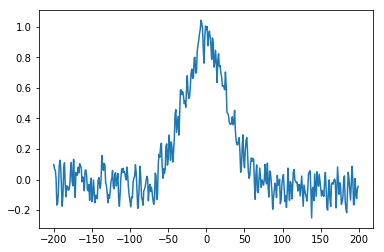

In [195]:
plt.plot(x,y)
plt.show()

## fit with scipy optimize or least squares to get good fit initial guess 

Will do for gaussian, lorenzian, and combination of polynomial backgrounds

In [196]:
#the two models to compare
def gaussian(c,x):
    #c[0] is amplitude, c[1] is position, and c[2] is width
    return (c[0]*np.exp(-(x-c[1])**2/(2*(c[2])**2))+c[3]+c[4]*x)

def gaussian_residuals(c,x,y):
    #c[0] is amplitude, c[1] is position, and c[2] is width
    return y-gaussian(c,x)

def cauchy(c,x):
    #c[0] is amplitude, c[1] is position, and c[2] is width
    return (c[0]*((x-c[1])**2+c[2]**2)**-1.0+c[3]+c[4]*x)

def cauchy_residuals(c,x,y):
    #c[0] is amplitude, c[1] is position, and c[2] is width
    return y-cauchy(c,x)

def voigt(c,x):
     return np.real(c[0]*special.wofz((x-c[1]+1j*c[2])/c[3])+c[4]+c[5]*x)

def voigt_residuals(c,x,y):
    return y-voigt(c,x)
    
    

In [197]:
x0 = np.array([1,0,40,0,0])
res_lsq_gaussian = optimize.least_squares(gaussian_residuals,x0,args=(x,y))
res_lsq_gaussian.x

array([  9.54554458e-01,  -8.06633906e-01,   2.76282069e+01,
        -3.96074637e-02,  -1.25513171e-04])

In [198]:
x0 = np.array([1,0,40,0,0])
res_lsq_cauchy = optimize.least_squares(cauchy_residuals,x0,args=(x,y))
res_lsq_cauchy.x

array([  9.05291734e+02,  -6.90088589e-01,  -2.89219130e+01,
        -9.77048974e-02,  -1.26445533e-04])

In [199]:
x0 = np.array([1,0,3,30,0,0])
res_lsq_voigt = optimize.least_squares(voigt_residuals,x0,args=(x,y))
res_lsq_voigt.x

array([  8.70767336e-01,  -8.05583916e-01,  -2.94123443e+00,
         4.11017794e+01,  -3.44504964e-02,  -1.25607934e-04])

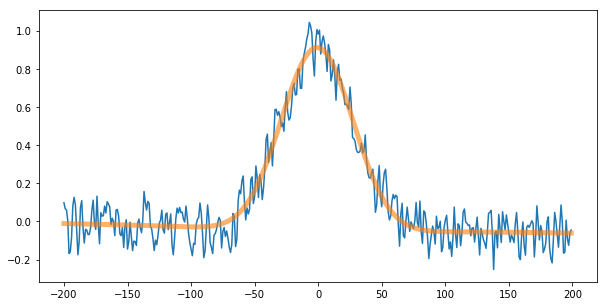

In [200]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
#plt.plot(x,gaussian(res_lsq_gaussian.x,x),linewidth=5,alpha=0.4)
plt.plot(x,voigt(res_lsq_voigt.x,x),linewidth=5,alpha=0.6)
#plt.plot(x,voigt(x0,x),linewidth=5)
plt.show()

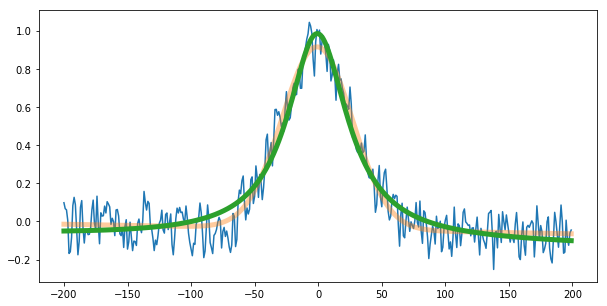

In [201]:
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.plot(x,gaussian(res_lsq_gaussian.x,x),linewidth=5,alpha=0.4)
plt.plot(x,cauchy(res_lsq_cauchy.x,x),linewidth=5)
plt.show()

an initial guess for the linear regression with hold outs is now ready. Now to linearize the cauchy and gaussian models above for use in the sklearn LinearRegression package

### Linearizing the system by making the Jacobian

In [202]:
### this can be removed in favor of more general snippet below
dx_size           =    1e-3 
gaussian_basis    =    [gaussian(res_lsq_gaussian.x,x)]
for i in np.arange(res_lsq_gaussian.x.shape[0]):
    
    x_plus_dx           = np.ones(res_lsq_gaussian.x.shape[0])
    x_plus_dx[i]        += 1+dx_size
    
    new_basis_item      = (gaussian(res_lsq_gaussian.x*x_plus_dx,x)-gaussian(res_lsq_gaussian.x,x))/(dx_size)
    
    gaussian_basis.append(new_basis_item)

gaussian_basis = np.vstack(gaussian_basis)

In [203]:
def make_augmented_jacobian(func,x,x0,dx):
    
    new_basis    =    [func(x0,x)]
    for i in np.arange(x0.shape[0]):

        x_plus_dx           = np.ones(x0.shape[0])
        x_plus_dx[i]        += 1+dx_size

        new_basis_element      = (func(x0*x_plus_dx,x)-func(x0,x))/(dx_size)

        new_basis.append(new_basis_element)

    new_basis = np.vstack(new_basis)
    
    return new_basis

In [204]:
cauchy_basis = make_augmented_jacobian(cauchy,x,res_lsq_cauchy.x,1e-3)
gaussian_basis = make_augmented_jacobian(gaussian,x,res_lsq_gaussian.x,1e-3)
voigt_basis = make_augmented_jacobian(voigt,x,res_lsq_voigt.x,1e-3)

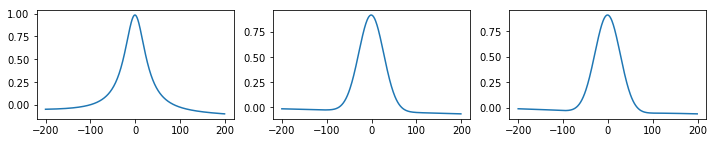

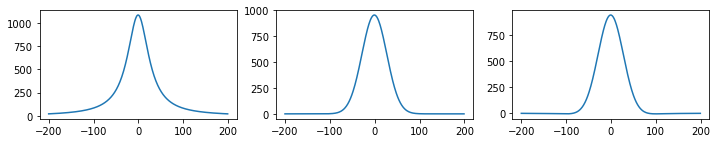

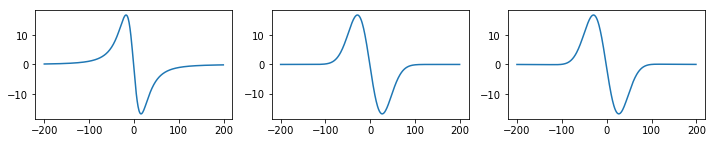

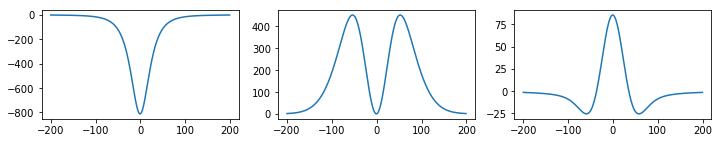

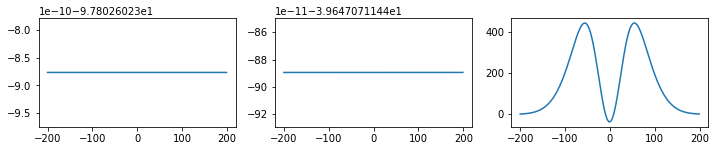

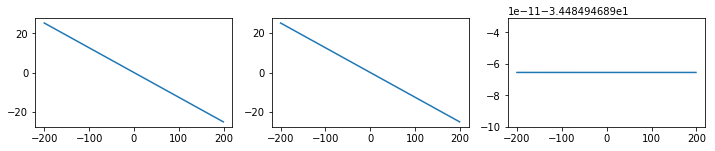

In [205]:
for i in np.arange(cauchy_basis.shape[0]):
    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(12,2)
    ax[0].plot(x,cauchy_basis[i])
    ax[1].plot(x,gaussian_basis[i])
    ax[2].plot(x,voigt_basis[i])
    plt.show()

### now using the scikit-learn module

In [206]:
#define estimator objects for . This will require
reg_gauss  = linear_model.LinearRegression().fit(gaussian_basis.transpose(), y)
reg_cauchy = linear_model.LinearRegression().fit(cauchy_basis.transpose(), y)
reg_voigt = linear_model.LinearRegression().fit(voigt_basis.transpose(), y)

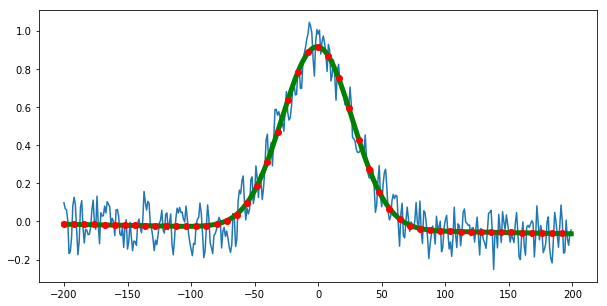

In [207]:
## regression using sklearn is working. now can compute cross validation score.  Then do same for cauchy fitting.
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.plot(x,gaussian(res_lsq_gaussian.x,x),linewidth=5,color='g')
plt.plot(x,reg_gauss.predict(gaussian_basis.transpose()),linewidth=0,color='r',marker='o',markevery=8)

plt.show()

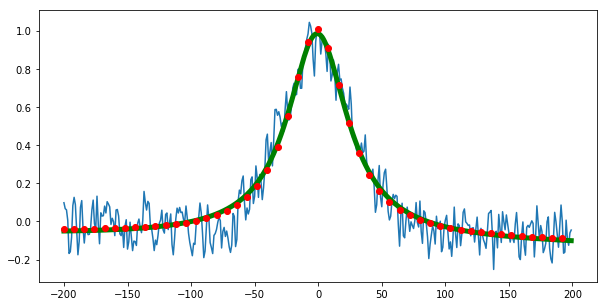

In [208]:
## regression using sklearn is working. now can compute cross validation score.  Then do same for cauchy fitting.
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.plot(x,cauchy(res_lsq_cauchy.x,x),linewidth=5,color='g')
plt.plot(x,reg_cauchy.predict(cauchy_basis.transpose()),linewidth=0,color='r',marker='o',markevery=8)

plt.show()

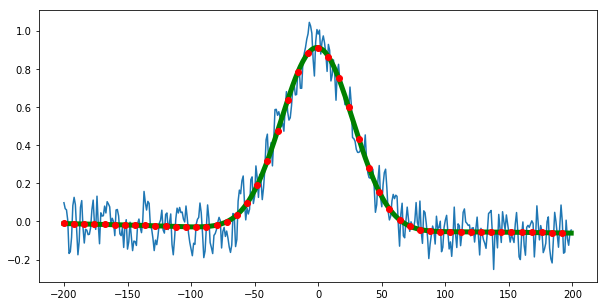

In [209]:
## regression using sklearn is working. now can compute cross validation score.  Then do same for cauchy fitting.
plt.figure(figsize=(10,5))
plt.plot(x,y)
plt.plot(x,voigt(res_lsq_voigt.x,x),linewidth=5,color='g')
plt.plot(x,reg_voigt.predict(voigt_basis.transpose()),linewidth=0,color='r',marker='o',markevery=8)

plt.show()

In [210]:
# cv integer uses k-fold
cauchy_scores = model_selection.cross_val_score(reg_cauchy,cauchy_basis.transpose(),y,cv=10,scoring="neg_mean_squared_error")
gauss_scores = model_selection.cross_val_score(reg_gauss,gaussian_basis.transpose(),y,cv=10,scoring="neg_mean_squared_error")
voigt_scores = model_selection.cross_val_score(reg_voigt,voigt_basis.transpose(),y,cv=10,scoring="neg_mean_squared_error")
print("gaussian cross val mean: "+str(np.mean(gauss_scores)) + "     stan_dev: " +str(np.std(gauss_scores)))
print("cauchy cross val mean: "+str(np.mean(cauchy_scores))  + "     stan_dev: " +str(np.std(cauchy_scores)))
print("voigt cross val mean: "+str(np.mean(voigt_scores))  + "     stan_dev: " +str(np.std(voigt_scores)))

gaussian cross val mean: -0.00673153429872     stan_dev: 0.00127713096301
cauchy cross val mean: -0.0110854713458     stan_dev: 0.00695063200615
voigt cross val mean: -0.00683987928148     stan_dev: 0.00114853460725


In [211]:
#using a shuffle and split instead
cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.1, random_state=None)
cauchy_scores = model_selection.cross_val_score(reg_cauchy,cauchy_basis.transpose(),y,cv=cv,scoring="neg_mean_squared_error")
gauss_scores = model_selection.cross_val_score(reg_gauss,gaussian_basis.transpose(),y,cv=cv,scoring="neg_mean_squared_error")
voigt_scores = model_selection.cross_val_score(reg_voigt,voigt_basis.transpose(),y,cv=cv,scoring="neg_mean_squared_error")
print("gaussian cross val mean: "+str(np.mean(gauss_scores)) + "     stan_dev: " +str(np.std(gauss_scores)))
print("cauchy cross val mean: "+str(np.mean(cauchy_scores))  + "     stan_dev: " +str(np.std(cauchy_scores)))
print("voigt cross val mean: "+str(np.mean(voigt_scores))  + "     stan_dev: " +str(np.std(voigt_scores)))

gaussian cross val mean: -0.00640303924806     stan_dev: 0.0011884991128
cauchy cross val mean: -0.00827584584935     stan_dev: 0.000929687932612
voigt cross val mean: -0.00681763778191     stan_dev: 0.00114568921368


In [193]:
help(reg_gauss.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.linear_model.base.LinearRegression instance
    Returns the coefficient of determination R^2 of the prediction.
    
    The coefficient R^2 is defined as (1 - u/v), where u is the regression
    sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual
    sum of squares ((y_true - y_true.mean()) ** 2).sum().
    Best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). A constant model that always
    predicts the expected value of y, disregarding the input features,
    would get a R^2 score of 0.0.
    
    Parameters
    ----------
    X : array-like, shape = (n_samples, n_features)
        Test samples.
    
    y : array-like, shape = (n_samples) or (n_samples, n_outputs)
        True values for X.
    
    sample_weight : array-like, shape = [n_samples], optional
        Sample weights.
    
    Returns
    -------
    score : float

### to do

1) study for the case of different noise levels.  Preliminary results indicate 

2) find different metric instead of score that can be iterated on using the cross_validate framework.  (found neg_mean_squared_error to pass to cross_val that maybe be more readily interpretable.)

3) or find rigorous theoretical underpinning for the 1-u/v score.